# GoogLeNet from scratch in PyTorch

Although designed in 2014, the Inception models (GoogLeNet) are still some of the most successful neural networks for image classification and detection. Their original article is a classic among machine learning research papers.

https://arxiv.org/abs/1409.4842

In [ ]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Architecture Implementation

Starting by the fundamental building block of a CNN, represented by a convolutional layer. Notably, Batch Normalization was not introduced when GoogleNet (Inception) came out but modern implementations include it. Inception v2 (https://arxiv.org/abs/1502.03167) apply Batch Normalization after every convolution (including the 1x1 bottlenecks), which speeds convergence and stabilizes training.

In [ ]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    GoogLeNet-style: Input -> Conv2d -> BatchNorm2d -> ReLU -> Output
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False,
                 norm=True, activation=None) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        # Batch Normalization to stabilize training
        self.norm= nn.BatchNorm2d(out_channels) if norm else None
        # Activation function -- ReLU is the default in GoogLeNet
        self.activation= nn.ReLU(inplace=True) if activation is None else activation


    def forward(self, x):
        x= self.conv(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activation(x)

        return x


The Inception module forwards the input through four parallel branches of filters with different sizes: 1x1, 3x3, and 5x5. Note that even a modest number of 5x5 convolutions can be expensive. This drawback was solved by applying dimension reduction and projections whenever the computational requirements would increase. That is, 1x1 conv is applied before expensive 3x3 and 5x5 convolutions to keep the computational cost maintainable.

The input tensor can be downsampled (through max-pooling) to reduce costs; however, we cannot perform downsampling too often; otherwise, information loss accumulates, which we want to avoid. 1x1 convolution solves this problem by pooling not inside a single channel but across the channels (keeps the image size stable while decreasing the number of channels).

Therefore, Inception processes visual information at various scales and concatenate the resulting smaller tensors side by side so that the next stage can abstract features from different scales simultaneously.

In [ ]:
class Inception(nn.Module):
    """
    Implements the Inception module with 4 parallel branches:
    - 1x1 convolution
    - 1x1 convolution followed by 3x3 convolution
    - 1x1 convolution followed by 5x5 convolution
    - 3x3 max pooling followed by 1x1 convolution
    The output of this module concatenates feature maps from all 4 branches.
    """

    def __init__(self, in_channels, out_ch1x1, in_ch3x3, out_ch3x3, in_ch5x5, out_ch5x5,
                 out_1x1_pool_proj, activation) -> None:
        super(Inception, self).__init__()
        # 1x1 convolution
        self.branch1= ConvLayer(in_channels, out_ch1x1, kernel_size=1, activation=activation)
        # 1x1 convolution followed by 3x3 convolution
        self.branch2= nn.Sequential(
            ConvLayer(in_channels, in_ch3x3, kernel_size=1, activation=activation),
            ConvLayer(in_ch3x3, out_ch3x3, kernel_size=3, padding=1, activation=activation)
        )
        # 1x1 convolution followed by 5x5 convolution
        self.branch3= nn.Sequential(
            ConvLayer(in_channels, in_ch5x5, kernel_size=1, activation=activation),
            ConvLayer(in_ch5x5, out_ch5x5, kernel_size=5, padding=2, activation=activation)
        )
        # 3x3 max pooling followed by 1x1 convolution
        self.branch4= nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            ConvLayer(in_channels, out_1x1_pool_proj, kernel_size=1, activation=activation)
        )


    def forward(self, x):
        branch1= self.branch1(x)
        branch2= self.branch2(x)
        branch3= self.branch3(x)
        branch4= self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], dim=1)


Given the relatively large depth of the network, the ability to propagate gradients back through all the layers is a concern. The authors solved this issue by adding auxiliary classifiers connected to some intermediate layers to encourage discrimination in the lower stages in the classifier, increase the gradient signal that gets propagated back, and provide additional regularization.

These **auxiliary classifiers** are smaller convolutional networks put on top of the output of the **Inception 4a and 4d modules**. During training, their loss is added to the total loss of the network with a discount weight (the losses of auxiliary classifiers are weighted by 0.3). At inference time, the auxiliary classifiers are discarded.

In [ ]:
class InceptionAux(nn.Module):
    """
    Auxiliary classifiers connected to intermediate layers (Inception 4a and 4d). During training,
    their loss gets added to the total loss of the network to increase the gradient signal that
    get propagated back and provide additional regularization.
    """

    def __init__(self, in_channels, num_classes, activation, dropout) -> None:
        super(InceptionAux, self).__init__()
        # Initial pooling
        self.pool= nn.AdaptiveAvgPool2d((4, 4))
        self.conv= ConvLayer(in_channels, 128, kernel_size=1, activation=activation)
        self.fc1= nn.Linear(4 * 4 * 128, 1024)
        self.activation= activation
        self.dropout= nn.Dropout(p=dropout)
        self.fc2= nn.Linear(1024, num_classes)


    def forward(self, x):
        x= self.pool(x)
        x= self.conv(x)
        x= torch.flatten(x, 1)
        x= self.fc1(x)
        x= self.activation(x)
        x= self.dropout(x)
        x= self.fc2(x)

        return x


# Building the GoogLeNet network

The network is 22 layers deep when counting only layers with parameters (or 27 layers if we also count pooling), but the code is organized into 5 convolutional stages (feature extractor) followed by a final classification head.

**Inception v2** (https://arxiv.org/abs/1502.03167) reduces the complexity of branch3 by factorizing its 5x5 conv with two sequential 3x3 convs (same receptive field as one 5x5 but with fewer parameters) and ReLU in between, giving more nonlinearity.

**Inception v3** (https://arxiv.org/abs/1512.00567) takes the v2 improvements further and adds new factorization ideas:

- **Asymmetric Convolutions:** A 3x3 conv can be replaced by a 1x3 followed by a 3x1 (further reducing cost), without loss in expressivity (also 7x7 -> 1x7 + 7x1).
- **Grid Size Reduction:** A pooling layer concatenated with a parallel 3x3 conv (both with stride 2).
- Simplified side heads.
- Label smoothing for training.

But the core multi-branch CONCAT idea remains.

In [ ]:
class GoogLeNet(nn.Module):
    """
    Implements the GoogLeNet architecture.
    """

    def __init__(self, in_channels, num_classes=1000, aux_logits=True, activation=None, dropout=0.2,
                 dropout_aux=0.7) -> None:
        super(GoogLeNet, self).__init__()
        # Activation function -- ReLU is the default in GoogLeNet
        activation= nn.ReLU(inplace=True) if activation is None else activation

        # Feature extractor -- ConvLayers 1 and 2
        self.conv1= ConvLayer(in_channels, 64, kernel_size=7, stride=2, padding=3, activation=activation)
        self.pool1= nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)
        self.conv2= nn.Sequential(
            ConvLayer(64, 64, kernel_size=1, activation=activation),
            ConvLayer(64, 192, kernel_size=3, padding=1, activation=activation),
        )
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        # Inception modules 3, 4, and 5
        # in_channels, out_ch1x1, in_ch3x3, out_ch3x3, in_ch5x5, out_ch5x5, out_1x1_pool_proj
        self.inception3= nn.Sequential(
            Inception(192,  64,  96, 128, 16, 32, 32, activation),
            Inception(256, 128, 128, 192, 32, 96, 64, activation),
        )
        self.pool3= nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.inception4a= Inception(480, 192,  96, 208, 16, 48, 64, activation)
        self.inception4b= Inception(512, 160, 112, 224, 24, 64, 64, activation)
        self.inception4c= Inception(512, 128, 128, 256, 24, 64, 64, activation)
        self.inception4d= Inception(512, 112, 144, 288, 32, 64, 64, activation)
        self.inception4e= Inception(528, 256, 160, 320, 32,128,128, activation)
        self.pool4= nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        # Auxiliar classifiers connected to Inception 4a and 4d (optional)
        if aux_logits:
            self.aux1= InceptionAux(512, num_classes, activation, dropout_aux)
            self.aux2= InceptionAux(528, num_classes, activation, dropout_aux)
        else:
            self.aux1= None
            self.aux2= None

        self.inception5= nn.Sequential(
            Inception(832, 256, 160, 320, 32, 128, 128, activation),
            Inception(832, 384, 192, 384, 48, 128, 128, activation),
        )

        # Pooling and classification head to produce the final class logits
        self.avgpool= nn.AdaptiveAvgPool2d((1, 1))
        self.head= nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(1024, num_classes),
        )

        # Initialize parameters with Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        x= self.pool1(self.conv1(x))
        x= self.pool2(self.conv2(x))
        x= self.pool3(self.inception3(x))
        x= self.inception4a(x)

        if self.aux1 is not None and self.training:
            aux1= self.aux1(x)
        else:
            aux1= None

        x= self.inception4b(x)
        x= self.inception4c(x)
        x= self.inception4d(x)

        if self.aux2 is not None and self.training:
            aux2= self.aux2(x)
        else:
            aux2= None

        x= self.pool4(self.inception4e(x))
        x= self.avgpool(self.inception5(x))
        x= torch.flatten(x, 1)
        x= self.head(x)

        return x, aux1, aux2


Using **torchvision** GoogLeNet architecture to get the parameter count, we see that the total parameters comes out to be 6,624,904. It's important to note that this architecture replaces all 5x5 convolutions with 3x3 convolutions (a known bug), resulting in a different parameter count. Ideally, the parameter count should align with the one we created, which is a total of 7,005,832 parameter.

In [ ]:
import torchvision.models as models
from torchvision.models import GoogLeNet_Weights

tvis_model= models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1).to(device)
count_parameters(tvis_model)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 172MB/s]


Number of parameters: 6624904


In [ ]:
img= torch.randn(1, 3, 224, 224).to(device)  # a single image batch
model= GoogLeNet(in_channels=3, aux_logits=False).to(device)
count_parameters(model)
out, _, _= model(img)
print(out.shape)

model

Number of parameters: 7005832
torch.Size([1, 1000])


GoogLeNet(
  (conv1): ConvLayer(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (conv2): Sequential(
    (0): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (inception3): Sequential(
    (0): Inception(
      (branc

# Training the GoogLeNet model from scratch

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [ ]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 32.8MB/s]


In [ ]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

In the original GoogleNet paper they compute:

$$
\mathcal{L} = \mathcal{L}_{main} + \alpha\mathcal{L}_{aux_1} + \alpha\mathcal{L}_{aux_2}
$$

where each $\mathcal{L}_{*}$ is the supervised classification loss (cross-entropy). The original paper used $\alpha = 0.3$ on each aux head.

TODO:

- Play with different learning rate values.
- More training epochs.
- Improved LR schedulers, e.g., Cosine decay with warmup.

In [ ]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, discount_loss=0.3, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits, logits_aux1, logits_aux2= model(images)
            loss= criterion(logits, labels)
            if logits_aux1 is not None and logits_aux2 is not None:
                loss += (discount_loss * criterion(logits_aux1, labels))
                loss += (discount_loss * criterion(logits_aux2, labels))
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits, _, _= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [ ]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits, _, _= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [ ]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32, Fused AdamW, and Label Smoothing

In [ ]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available


# --- GoogLeNet ---
in_channels= 3
num_classes= 10
dropout= 0.1
dropout_aux= 0.5

model= GoogLeNet(in_channels, num_classes, dropout=dropout, dropout_aux=dropout_aux).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 5e-4

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss(label_smoothing=0.1)
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)


Number of parameters: 10341566
Using fused AdamW: True


In [ ]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, discount_loss=0.3, verbose=True)

Epoch: 0 | Train Loss: 2.4615 | Val Loss: 1.3832 | dt/epoch: 82703.98ms
Epoch: 1 | Train Loss: 1.8515 | Val Loss: 1.1233 | dt/epoch: 81818.11ms
Epoch: 2 | Train Loss: 1.6141 | Val Loss: 1.0083 | dt/epoch: 81571.56ms
Epoch: 3 | Train Loss: 1.4769 | Val Loss: 0.9938 | dt/epoch: 82008.37ms
Epoch: 4 | Train Loss: 1.3897 | Val Loss: 0.9280 | dt/epoch: 81658.56ms
Epoch: 5 | Train Loss: 1.3178 | Val Loss: 0.8731 | dt/epoch: 81350.17ms
Epoch: 6 | Train Loss: 1.2554 | Val Loss: 0.9882 | dt/epoch: 81932.09ms
Epoch: 7 | Train Loss: 1.2034 | Val Loss: 0.8392 | dt/epoch: 81699.19ms
Epoch: 8 | Train Loss: 1.1650 | Val Loss: 0.7646 | dt/epoch: 81260.35ms
Epoch: 9 | Train Loss: 1.1322 | Val Loss: 0.7921 | dt/epoch: 81910.11ms
Epoch: 10 | Train Loss: 1.0959 | Val Loss: 0.8557 | dt/epoch: 82125.29ms
Epoch: 11 | Train Loss: 1.0727 | Val Loss: 0.8341 | dt/epoch: 81308.84ms
Epoch: 12 | Train Loss: 1.0422 | Val Loss: 0.7846 | dt/epoch: 81329.18ms
Epoch: 13 | Train Loss: 0.9477 | Val Loss: 0.6862 | dt/epoch:

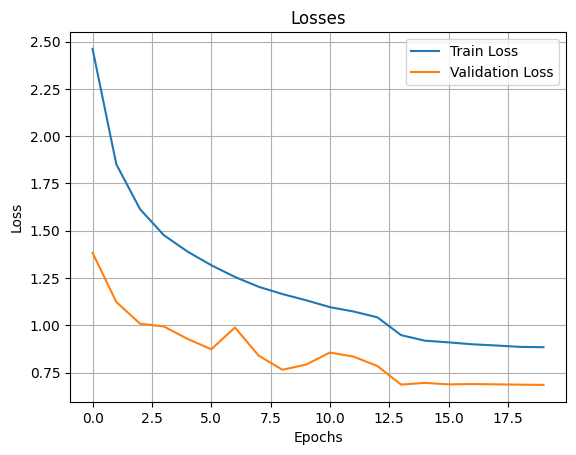

In [ ]:
# plot
plot_losses(tr_loss, vl_loss)

In [ ]:
effnetv1_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 91.89%


In [ ]:
# https://medium.com/aiguys/going-deeper-with-convolutions-the-inception-paper-explained-841a0c661fd3
# https://medium.com/@karuneshu21/implement-inception-v1-in-pytorch-66bdbb3d0005
# https://sahiltinky94.medium.com/know-about-googlenet-and-implementation-using-pytorch-92f827d675db
# https://medium.com/nerd-for-tech/know-about-inception-v2-and-v3-implementation-using-pytorch-b1d96b2c1aa5